In [46]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import MDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_selection import chi2
import os, sys
import glob
import gensim
from gensim.corpora import Dictionary
from gensim.similarities import MatrixSimilarity
from gensim.models import ldamodel, doc2vec, LsiModel, LdaModel, CoherenceModel
from gensim.matutils import kullback_leibler, jaccard, hellinger, sparse2full
import nltk
# nltk.download('punkt')
import string
import csv
import math
import statistics
import datetime
from nltk.corpus import stopwords
from nltk.util import ngrams
# nltk.download('stopwords')
from collections import OrderedDict, Counter, namedtuple
import networkx as nx
import matplotlib.pyplot as plt
from networkx.readwrite import json_graph
from bokeh.plotting import figure, show, output_file
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.layouts import row, column
from progress.bar import IncrementalBar
import warnings
warnings.filterwarnings('ignore')

In [31]:
### Load in data for issues and each page of all issues
df_issues = pd.read_csv('../data/arab_observer_1960_1962_stopwords_aggregating.csv')
df_pages = pd.read_csv('../data/arab_observer_1960_1962_stopwords.csv')
df_issues.month[df_issues.month == 'Oct'] = 'October'
df_issues.month[df_issues.month == 'Aug'] = 'August'
df_issues.month[df_issues.month == 'Sept'] = 'September'

In [32]:
df_hathi = pd.read_csv('../data/hathi_trust_1963_1966_stopwords_aggregating.csv')

In [33]:
df_join = df_hathi.drop(['htrc_vol', 'second_month', 'second_month_index'], axis=1)
df_join.rename(columns={'first_month': 'month'}, inplace=True)
df_join.rename(columns={'first_month_index': 'month_index'}, inplace=True)
df_join.rename(columns={'page': 'page_number'}, inplace=True)
df_join['day'] = '01'
df_join['date'] = df_join.date + '-' + df_join.day
df_join['type'] = 'hathi_trust'

df_join1 = df_issues.drop(['vol', 'Unnamed: 0'], axis=1)
df_join1['month_index'] = pd.to_datetime(df_join1['month'], format='%B', errors='coerce').dt.month
df_join1['type'] = 'collected_issues'

df = pd.concat([df_join, df_join1])
df.columns

Index(['Unnamed: 0', 'date', 'day', 'month', 'month_index', 'page_number',
       'spacy_counts', 'spacy_text', 'tokenized_counts', 'tokenized_text',
       'type', 'year'],
      dtype='object')

In [38]:
df.page_number

0      703
1      674
2      796
3      700
4      928
5      995
6      919
7      852
8      868
9      916
10     431
0       36
1       35
2       33
3       35
4       35
5       33
6       35
7       35
8       10
9       36
10      35
11      36
12      37
13      36
14      36
15      16
16      66
17      36
18      36
      ... 
74      35
75      35
76      55
77      58
78      57
79      54
80      55
81      60
82      56
83      55
84      57
85      52
86      55
87      54
88      53
89      35
90      36
91      36
92      33
93      36
94      36
95      36
96      37
97      35
98      36
99      33
100     36
101     35
102     35
103     33
Name: page_number, Length: 115, dtype: int64

In [23]:
def custom_tokenize(text):
    if not text:
#       print('The text to be tokenized is a None type. Defaulting to blank string.')
        text = ''
    return nltk.sent_tokenize(text)
def join_token_lists(rows):
    print(rows)
    texts = rows
    final_doc = []
    sentences = []
    for line in texts:
        sentences.extend(nltk.sent_tokenize(line))
    for sentence in sentences:
        sent_tokens = [token.lower() for token in nltk.word_tokenize(sentence) if token not in string.punctuation and token not in stopwords.words('english') and token.isdigit() == False]


        final_doc.append(sent_tokens)
    print(len(final_doc))
    return final_doc

def join_token_terms(rows):

    texts = rows.astype(str).tolist()
    final_doc = []
    for t in texts: 
        page_terms = ''
        tokens = custom_tokenize(t)
        for t in tokens:
            if t in string.punctuation:
                continue
            elif t in stopwords.words('english'):
                continue
                
            elif t.isdigit():
                continue
            else:
                
                page_terms += t.lower() + ' '
        
        final_doc.append(page_terms)
    print(len(final_doc))
    return final_doc

In [36]:

def custom_tokenize(text):
    if not text:
#       print('The text to be tokenized is a None type. Defaulting to blank string.')
        text = ''
    return nltk.sent_tokenize(text)
def join_token_lists(rows):
    print(len(rows))
    texts = rows
    final_doc = []
#     sentences = []
    for line in texts:
        print(len(line))
#         sentences.extend(nltk.sent_tokenize(line))
#     for sentence in sentences:
#         sent_tokens = [token.lower() for token in nltk.word_tokenize(sentence) if token not in string.punctuation and token not in stopwords.words('english') and token.isdigit() == False]


#         final_doc.append(sent_tokens)
#     print(len(final_doc))
    return final_doc

def join_token_terms(rows):

    texts = rows.astype(str).tolist()
    final_doc = []
    for t in texts: 
        page_terms = ''
        tokens = custom_tokenize(t)
        for t in tokens:
            if t in string.punctuation:
                continue
            elif t in stopwords.words('english'):
                continue
                
            elif t.isdigit():
                continue
            else:
                
                page_terms += t.lower() + ' '
        
        final_doc.append(page_terms)
    print(len(final_doc))
    return final_doc


def get_texts(rows):
    print(rows)
test = df.groupby(['year'])['tokenized_text'].apply(join_token_lists).reset_index()
print()

13
94175
91471
93534
81269
90645
90675
74712
104421
93232
92651
90211
88882
89870
38
98046
80254
81563
83267
87138
85035
95274
96814
20989
88447
85623
82338
80058
84327
94340
36910
158884
83045
85866
77198
85357
94368
75730
76083
79396
85454
77351
76670
91211
93048
93048
80525
95551
101354
99503
94568
90326
97851
53
90688
87967
81001
86213
88436
118718
156294
135382
121567
139522
130101
108546
137789
89600
86455
90463
93807
94504
96133
96816
78803
120174
170835
110794
136755
130975
84877
90261
91491
80492
76474
119178
85261
85760
93394
83727
83108
79244
137169
134663
130349
127521
126982
143440
135406
138722
123030
124627
138984
134609
144958
86149
90397
4
1315329
1388951
1462148
1261984
3
2077756
2289929
2071506
2
1816173
2034386
2
2427831
1302203
   year tokenized_text
0  1960             []
1  1961             []
2  1962             []
3  1963             []
4  1964             []
5  1965             []
6  1966             []


In [41]:
test2 = df.groupby(['year'])['tokenized_counts'].sum().reset_index()
test2

,year,tokenized_counts
0,1960,166765
1,1961,469034
2,1962,844048
3,1963,748309
4,1964,879757
5,1965,538635
6,1966,501289


In [263]:
df = pd.read_csv('../scripts/all_years_data_tm.csv')
df_1960 = df.loc[df.year == 1960 ]
# df_1961 = df.loc[df.year == 1961 ]
len(df_1960)

1

In [248]:
def custom_tokenize(text):
    if not text:
#       print('The text to be tokenized is a None type. Defaulting to blank string.')
        text = ''
    return nltk.sent_tokenize(text)
def join_token_terms(rows):
    print(len(rows))
    texts = rows.astype(str).tolist()
    print(len(texts))
    final_doc = []
#     for t in texts: 
#         pages = []
#         tokens = custom_tokenize(t)
#         for t1 in tokens:
#             page_terms = ''
#             toks = nltk.word_tokenize(t1)
#             for t in toks:
#                 if t in string.punctuation:
#                     continue
#                 elif t in stopwords.words('english'):
#                     continue
                    
#                 elif t.isdigit():
#                     continue
#                 else:
#                     page_terms += t.lower() + ' '
#             pages.append(page_terms)
#         final_doc.append(pages)
#     print(len(final_doc))
    return final_doc

df_1 = pd.read_csv('../notebooks/all_combined_data_1960_1966.csv')
# print(len(df_1.loc[df_1.year == 1960]))
df_tokens = df_1.groupby(['year'])['tokenized_text'].apply(join_token_terms).reset_index()

13
13
38
38
53
53
4
4
3
3
2
2
2
2


In [283]:
df = pd.read_csv('../scripts/all_years_data_tm.csv')
# model_texts = []
# def get_texts(rows):
#     print(len(literal_eval(rows.values[0])))
    
#     x = literal_eval(rows.values[0])
# #     t = ' '.join(x)
# #     print(len(t))
#     model_texts.extend(x)
#     return x

# df_grouped = df.groupby(['year'])['token_lists'].apply(get_texts)

df.year

0    1960
1    1961
2    1962
3    1963
4    1964
5    1965
6    1966
Name: year, dtype: int64

In [262]:
zero[0]

"weekly middle east news magazine ja arab observer evard wb3377 odb7 see page ne w libya august prices .bs mts .kr1,15 ptmk un ... dm .. dr. asse rtals :3gë -- .38°es van ... dis o.m pr tanta cent t. kr 1.15 mnes ... ... 1/6 harvard university library oct artd.. pt kn blasia din king idriss el senoussi brilliance fashion -- alexandria contest arab observer index vol 1- august arab world arab unity enhanced danger – new libya « arab observer » published weekly u.a.r affairs -- towards better relations turkey -- development scientific lines agricultural mission u.s.a editor-in-chief mahmoud amr publisher middle east research centre political roundup security council resolution belgium exerts pressure laos east cuba west third bloc distributed national publications house sharia mansour cairo price u.a.r pt african continent triumph peace annual subscription l.e economy central bank established regulate banking business normal conditions cotton trade restored canal improvements cover story

In [206]:
word_dist = nltk.FreqDist(frames)

# stopwords = nltk.corpus.stopwords.words('english')
# words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 

# print('All frequencies, including STOPWORDS:')
# print('=' * 60)
rslt = pd.DataFrame(word_dist.most_common(100),columns=['Word', 'Frequency'])
# plot
rslt

,Word,Frequency
0,'s,1624
1,arab,1410
2,«,1409
3,said,810
4,people,746
5,would,661
6,president,659
7,world,652
8,israel,651
9,uar,647


In [142]:
from ast import literal_eval
zero = literal_eval(df_1960.token_lists.values[0])
dictionary_zero = Dictionary(zero)
corpus_zero = [dictionary_zero.doc2bow(text) for text in zero]
model_zero = LdaModel(corpus=corpus_zero, id2word=dictionary_zero, iterations=50, num_topics=10)

one = literal_eval(df_1961.token_lists.values[0])
dictionary_one = Dictionary(one)
corpus_one = [dictionary_zero.doc2bow(text) for text in one]
model_one = LdaModel(corpus=corpus_one, id2word=dictionary_one, iterations=50, num_topics=40)


In [51]:
# def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
#     """
#     Compute c_v coherence for various number of topics

#     Parameters:
#     ----------
#     dictionary : Gensim dictionary
#     corpus : Gensim corpus
#     texts : List of input texts
#     limit : Max num of topics

#     Returns:
#     -------
#     model_list : List of LDA topic models
#     coherence_values : Coherence values corresponding to the LDA model with respective number of topics
#     """
#     coherence_values = []
#     model_list = []
#     for num_topics in range(start, limit, step):
#         print(num_topics)
#         model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
#         model_list.append(model)
#         coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
#         coherence_values.append(coherencemodel.get_coherence())

#     return model_list, coherence_values
# limit=150; start=2; step=5;
# x = range(start, limit, step)
# model_list, coherence_values = compute_coherence_values(dictionary=dictionary_zero, corpus=corpus_zero, texts=zero, start=2, limit=150, step=5)
# # # # Show graph


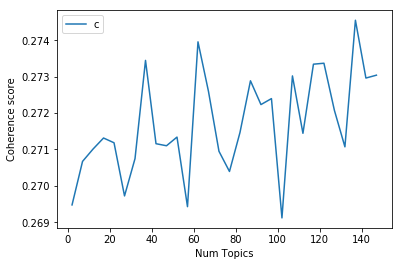

In [50]:

plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [147]:
def make_topics_bow(topic):
#     print(topic)
#     # takes the string returned by model.show_topics()
#     # split on strings to get topics and the probabilities
#     topic = topic.split('+')
#     # list to store topic bows
    topic_bow = []
    for word in topic:
#         print(word)
#         # split probability and word
        word, prob = word
#         # get rid of spaces
        word = word.replace(" ","")
#         # convert to word_type
        word = model_tfidf.id2word.doc2bow([word])[0][0]
        topic_bow.append((word, float(prob)))
    return topic_bow

def make_topics_bow2(topic):
#     print(topic)
#     # takes the string returned by model.show_topics()
#     # split on strings to get topics and the probabilities
#     topic = topic.split('+')
#     # list to store topic bows
    topic_bow = []
    for word in topic:
#         print(word)
#         # split probability and word
        word, prob = word
#         # get rid of spaces
        word = word.replace(" ","")
#         # convert to word_type
        word = model_one.id2word.doc2bow([word])[0][0]
        topic_bow.append((word, float(prob)))
    return topic_bow
frames = []
num_topics = 40
for t in range(num_topics):
#     if t+1 < num_topics:
#         print(t, t+1)
    test_1 = model_tfidf.show_topic(t, topn=len(model_tfidf.id2word))
    finance_distribution = make_topics_bow(test_1)
    for to in range(num_topics):
    
        test_2 = model_one.show_topic(to, topn=len(model_zero.id2word))
        
        
        water_distribution = make_topics_bow2(test_2)
        h = hellinger(water_distribution, finance_distribution)
#         kl = kullback_leibler(water_distribution, finance_distribution)
        print(str(t), str(to), 'h ', h)
#         d = {}
#         d['topic_1'] = str(t)
#         d['topic_2'] = str(to)
#         d['hellinger'] = h
#         dl = pd.DataFrame().append(d, ignore_index=True)
#         frames.append(dl)
# df_1960_61 = pd.concat(frames)

0 0 h  0.7057843286996797
0 1 h  0.6913981663651874
0 2 h  0.6630594840358278
0 3 h  0.7042890850632358
0 4 h  0.7011597262226095
0 5 h  0.6928396346321932
0 6 h  0.6927044599935438
0 7 h  0.689818878737166
0 8 h  0.6920699066403703
0 9 h  0.7042073986123284
0 10 h  0.6998794272351517
0 11 h  0.6879414671476963
0 12 h  0.6944810026125596
0 13 h  0.7091803837255574
0 14 h  0.7119386550417307
0 15 h  0.6996356113381877
0 16 h  0.7167005104170929
0 17 h  0.7086474199231201
0 18 h  0.6963957795483818
0 19 h  0.6988530343175171
0 20 h  0.692722928098532
0 21 h  0.7046543016931751
0 22 h  0.7006334462174926
0 23 h  0.7200291787912422
0 24 h  0.684914686825003
0 25 h  0.7047889597608358
0 26 h  0.7156159088862555
0 27 h  0.7042345469849101
0 28 h  0.6884469357150561
0 29 h  0.6841046926010639
0 30 h  0.7078338007594318
0 31 h  0.6952970412087669
0 32 h  0.7128948434953987
0 33 h  0.6976958788792311
0 34 h  0.7148415161257822
0 35 h  0.6914277410830822
0 36 h  0.7083570617671978
0 37 h  0.6991

7 28 h  0.6869180089118089
7 29 h  0.6825196096300712
7 30 h  0.7063695018099131
7 31 h  0.6938103978422571
7 32 h  0.7114454604411763
7 33 h  0.6962314649990484
7 34 h  0.7133556220935362
7 35 h  0.6899414806533952
7 36 h  0.7069140571185696
7 37 h  0.6977702687319064
7 38 h  0.6705226174927164
7 39 h  0.6896481503806321
8 0 h  0.7048677647715839
8 1 h  0.6903232753695491
8 2 h  0.6618750365445601
8 3 h  0.7033267544694036
8 4 h  0.7001518854611827
8 5 h  0.6918293073225551
8 6 h  0.691703721293636
8 7 h  0.6887978249241704
8 8 h  0.6910790728344371
8 9 h  0.7032789474955274
8 10 h  0.6988906678973692
8 11 h  0.6869031281991764
8 12 h  0.6935113461077802
8 13 h  0.7081843603501496
8 14 h  0.710999291603961
8 15 h  0.6986443070333448
8 16 h  0.7157748726146893
8 17 h  0.7076515284811851
8 18 h  0.6954220957100015
8 19 h  0.697914864674225
8 20 h  0.6917617276314815
8 21 h  0.7036961027582977
8 22 h  0.6996097703701739
8 23 h  0.7191075741902628
8 24 h  0.6838825141799637
8 25 h  0.7037

15 9 h  0.7029465910413161
15 10 h  0.6985644330126685
15 11 h  0.6865982088453416
15 12 h  0.6931650292581856
15 13 h  0.707847397751038
15 14 h  0.7106845275388594
15 15 h  0.6983030221670843
15 16 h  0.7154288117691132
15 17 h  0.7073248032558027
15 18 h  0.6951163110162013
15 19 h  0.697620066280713
15 20 h  0.6914291614783609
15 21 h  0.7033657056408471
15 22 h  0.6993111567165439
15 23 h  0.7187805025594858
15 24 h  0.6835690285976431
15 25 h  0.703451213101085
15 26 h  0.7144872177124051
15 27 h  0.7029139093430053
15 28 h  0.6870766220655775
15 29 h  0.6826270539429791
15 30 h  0.7065477540147042
15 31 h  0.6939851275472657
15 32 h  0.7116275276716161
15 33 h  0.6963735843334735
15 34 h  0.7135201435041211
15 35 h  0.6901264354118376
15 36 h  0.7071001843158464
15 37 h  0.6979155532824796
15 38 h  0.6706590084915512
15 39 h  0.6898057288927814
16 0 h  0.7047691562606401
16 1 h  0.6902228036116675
16 2 h  0.661776367968241
16 3 h  0.7032260735358166
16 4 h  0.7000569284772836
16

22 26 h  0.7171649944983752
22 27 h  0.7057695477263828
22 28 h  0.6900447889291038
22 29 h  0.6856752409728644
22 30 h  0.709394393956101
22 31 h  0.6967997052817301
22 32 h  0.7144284779220553
22 33 h  0.6992954164398687
22 34 h  0.7163649222260654
22 35 h  0.6930315531939556
22 36 h  0.7100483369346487
22 37 h  0.7007708230940994
22 38 h  0.673716007216528
22 39 h  0.6926816723542367
23 0 h  0.7056483401025075
23 1 h  0.6911942708559138
23 2 h  0.6628486598147665
23 3 h  0.7041113501346753
23 4 h  0.7009187448928731
23 5 h  0.6926033836285505
23 6 h  0.6926198060181591
23 7 h  0.6896554268634927
23 8 h  0.6918192899222017
23 9 h  0.704074615135477
23 10 h  0.699720744385685
23 11 h  0.6877143694843321
23 12 h  0.6942472937816941
23 13 h  0.7090355782081482
23 14 h  0.71178712304614
23 15 h  0.6993679617516325
23 16 h  0.7165696454938763
23 17 h  0.7084853798007337
23 18 h  0.6962201715765887
23 19 h  0.6987274765084444
23 20 h  0.692539804308902
23 21 h  0.7044720485526644
23 22 h  

KeyboardInterrupt: 

In [120]:
model_one.show_topic(4, topn=10)


[("'s", 0.010832537),
 ('195,000', 0.007441435),
 ('diversification', 0.0046359645),
 ('iarger', 0.004333634),
 ('vilion', 0.0042695077),
 ('chiefly', 0.0038544314),
 ('constantine', 0.0036073327),
 ('...', 0.0034917102),
 ('3,305,000', 0.003452082),
 ('afore-men', 0.0034446495)]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x145a65be0>]],
      dtype=object)

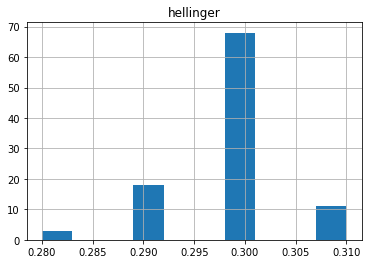

In [94]:
df_1960_61.hellinger = df_1960_61.hellinger.round(2)
df_1960_61.hist(column='hellinger')

In [95]:
df_1960_61.sort_values(by=['hellinger'])

,hellinger,topic_1,topic_2
0,0.28,5,2
0,0.28,5,3
0,0.28,5,9
0,0.29,9,9
0,0.29,5,4
0,0.29,5,5
0,0.29,5,6
0,0.29,5,7
0,0.29,5,8
0,0.29,7,1


In [136]:
tfidf_model = TfidfVectorizer(ngram_range=(1,1)) # default unigram model
tfidf= tfidf_model.fit_transform(literal_eval(df_1961.token_texts.values[0]))

In [137]:
corpus_vect = gensim.matutils.Sparse2Corpus(tfidf, documents_columns=False)

dictionary_vect = Dictionary.from_corpus(corpus_vect,
                                    id2word=dict((id, word) for word, id in tfidf_model.vocabulary_.items()))

In [143]:
model_tfidf = LdaModel(corpus=corpus_vect, id2word=dictionary_vect, iterations=50, num_topics=40)

In [148]:
model_one.show_topics(num_topics=40,formatted=False,num_words=20)

[(0,
  [('195,000', 0.012030408),
   ("'s", 0.011041607),
   ('...', 0.006678906),
   ('chiefly', 0.006560437),
   ('diversification', 0.0052283364),
   ('constantine', 0.005201291),
   ('vilion', 0.0048029693),
   ('afore-men', 0.0040107253),
   ('mils', 0.0039809993),
   ('men', 0.003816226),
   ('120,000', 0.0037834118),
   ('ple', 0.0036169672),
   ('story', 0.0035140922),
   ('copies', 0.0033203156),
   ('completion', 0.0032978046),
   ('charged', 0.0031103038),
   ('3,305,000', 0.0030900324),
   ('consequences', 0.0030786009),
   ('annual', 0.0029275343),
   ('iarger', 0.0027943144)]),
 (1,
  [("'s", 0.009702907),
   ('195,000', 0.007014012),
   ('chiefly', 0.005271509),
   ('diversification', 0.005078691),
   ('vilion', 0.0047942423),
   ('constantine', 0.004745159),
   ('charged', 0.004195486),
   ('iarger', 0.004017154),
   ('men', 0.0034529679),
   ('story', 0.0034223755),
   ('ambassador', 0.003201874),
   ('completion', 0.003068298),
   ('afore-men', 0.0028648197),
   ('app

In [149]:
model_tfidf.show_topics(num_topics=40,formatted=False,num_words=20)

[(0,
  [('the', 0.0007298175),
   ('arab', 0.00038592942),
   ('people', 0.00029350133),
   ('said', 0.00029259722),
   ('in', 0.00025789085),
   ('one', 0.00021440377),
   ('president', 0.00020295747),
   ('would', 0.00020005264),
   ('abdel', 0.00019999003),
   ('new', 0.0001994018),
   ('world', 0.00019742691),
   ('it', 0.00019229359),
   ('africa', 0.00017975943),
   ('government', 0.000177313),
   ('el', 0.00017687089),
   ('uar', 0.00017599956),
   ('israel', 0.00017045942),
   ('he', 0.00016477377),
   ('nasser', 0.00016246348),
   ('united', 0.00015284358)]),
 (1,
  [('the', 0.00034894358),
   ('african', 0.00020755176),
   ('arab', 0.00018494196),
   ('eichmann', 0.00017930965),
   ('clarke', 0.00013331574),
   ('conference', 0.0001318756),
   ('uar', 0.000116217074),
   ('in', 0.00011489675),
   ('said', 0.000113814975),
   ('it', 0.00011128884),
   ('people', 0.000109928114),
   ('crossman', 0.0001088714),
   ('countries', 0.00010524916),
   ('one', 0.00010336618),
   ('afr

In [157]:

lda_1960 = pd.read_csv('../scripts/1960_all_lda_words.csv')
# lda_1961 = pd.read_csv('../scripts/1961_all_lda_words.csv')
# lda_1962 = pd.read_csv('../scripts/1962_all_lda_words.csv')
# lda_1963 = pd.read_csv('../scripts/1963_all_lda_words.csv')
# lda_1964 = pd.read_csv('../scripts/1964_all_lda_words.csv')
# lda_1965 = pd.read_csv('../scripts/1965_all_lda_words.csv')
# lda_1966 = pd.read_csv('../scripts/1966_all_lda_words.csv')

print('1960',len(lda_1960))
# print('1961',list(lda_1961.word.unique()))
# print('1962',list(lda_1962.word.unique()))
# print('1963',list(lda_1963.word.unique()))
# print('1964',list(lda_1964.word.unique()))
# print('1965',list(lda_1965.word.unique()))
# print('1966',list(lda_1966.word.unique()))

1960 150804


In [161]:
len(lda_1960.loc[lda_1960.topic_weight > 0.3])

53809

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1433e71d0>]],
      dtype=object)

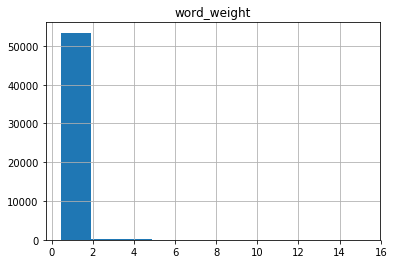

In [177]:
test1 = lda_1960.loc[lda_1960.topic_weight > 0.3]
# len(test1.loc[test1.word_weight])
test1.word_weight = test1.word_weight *10000
test1.hist(column='word_weight')

In [186]:
test2 = test1.loc[test1.word_weight  > 2]

In [187]:
test2

,doc_page,topic_id,topic_weight,word,word_weight,year
80,0.0,30.0,0.328281,the,14.268083,1960
81,0.0,30.0,0.328281,arab,9.337990,1960
82,0.0,30.0,0.328281,people,5.278191,1960
83,0.0,30.0,0.328281,in,4.839833,1960
84,0.0,30.0,0.328281,said,4.767333,1960
85,0.0,30.0,0.328281,israel,4.615086,1960
86,0.0,30.0,0.328281,president,4.125586,1960
87,0.0,30.0,0.328281,uar,4.065741,1960
88,0.0,30.0,0.328281,ayub,3.495195,1960
89,0.0,30.0,0.328281,it,3.492624,1960


In [281]:
df = pd.read_csv('../data/combined_all_data_ner_congo.csv')
df.columns

Index(['Unnamed: 0', 'date', 'day', 'month', 'month_index', 'page_number',
       'spacy_counts', 'spacy_text', 'string_date', 'term', 'tokenized_counts',
       'tokenized_text', 'word_counts', 'year', 'datetime'],
      dtype='object')

In [280]:
test = df.loc[df.year == 1960]
literal_eval(test.token_texts.values[0])

["arab observer index vol 1- no 8 august 14 1960 the arab world arab unity enhanced danger – new libya « arab observer » published weekly u.a.r affairs -- towards better relations turkey -- development scientific lines agricultural mission u.s.a editor-in-chief mahmoud amr 13 publisher middle east research centre political roundup security council resolution belgium exerts pressure laos east cuba west third bloc 17 distributed the national publications house 30 sharia mansour cairo price u.a.r pt 5 the african continent triumph peace annual subscription l.e 3 20 economy central bank established regulate banking business normal conditions cotton trade restored canal improvements cover story 26 new libya page 7 press and radio opinion false argument israel suez canal -- katanga belgium 's responsibility financial concerns ",
 "_cartoons nixon i 'll smash russia 1 ... kennedy if anyone is to smash russia i 'll do it ... and both of us seek nothing but world peace reproduced akhbar e1 yom 